In [1]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Input, Lambda ,Dense ,Flatten , Dropout , GlobalAveragePooling2D


Using TensorFlow backend.


In [2]:
#vgg 16 model
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')
classifier_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [3]:
#not train top layers
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [4]:
#adding extra layers for our class/images
main_model = classifier_vgg16.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(512,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(5,activation='softmax')(main_model)

In [5]:
#compiling
model = Model(inputs = classifier_vgg16.input , outputs = main_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Part 2 - Fitting the CNN to the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#use the image data generator to import the images from the dataset
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
#makes sure you provide the same target as initialised for the image size
training_set = train_datagen.flow_from_directory('G:/projects/face recognition transfer learning/dataset/train',
                                                 target_size=(64, 64),
                                                 batch_size=15,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('G:/projects/face recognition transfer learning/dataset/val',
                                            target_size=(64, 64),
                                            batch_size=10,
                                            class_mode='categorical',
                                            shuffle=False)

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [10]:
#fit the model
#it will take some time to train
nb_train_samples=1190
nb_validation_samples=170
batch_size=5

history = model.fit_generator(training_set,
                              validation_data=test_set,
                              epochs=5,
                              steps_per_epoch=nb_train_samples // batch_size,
                              validation_steps=nb_validation_samples // batch_size)

Epoch 1/5
238/238 [==============================] - 136s 572ms/step - loss: 0.2257 - accuracy: 0.9209 - val_loss: 1.9300 - val_accuracy: 0.6316
Epoch 2/5
238/238 [==============================] - 149s 625ms/step - loss: 0.0933 - accuracy: 0.9681 - val_loss: 0.9282 - val_accuracy: 0.6842
Epoch 3/5
238/238 [==============================] - 135s 565ms/step - loss: 0.0779 - accuracy: 0.9750 - val_loss: 7.1524e-06 - val_accuracy: 0.6464
Epoch 4/5
238/238 [==============================] - 127s 532ms/step - loss: 0.0750 - accuracy: 0.9747 - val_loss: 2.9484 - val_accuracy: 0.7123
Epoch 5/5
238/238 [==============================] - 147s 619ms/step - loss: 0.0782 - accuracy: 0.9772 - val_loss: 2.5760 - val_accuracy: 0.6351


In [11]:
model.save("G:/projects/face recognition transfer learning/face_recog_vgg_new.h5")

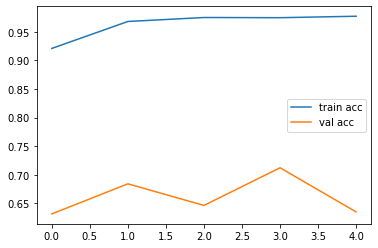

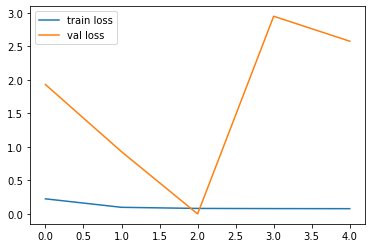

In [12]:
#PLOTTING accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , label = 'train acc')
plt.plot(history.history['val_accuracy'] , label = 'val acc')
plt.legend()
plt.show()

#PLOTTING loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , label = 'train loss')
plt.plot(history.history['val_loss'] , label = 'val loss')
plt.legend()
plt.show()

In [3]:
from keras.models import load_model
classifier = load_model('G:/projects/face recognition transfer learning/face_recog_vgg_new.h5')

In [11]:
from PIL import Image 
import base64
from io import BytesIO
import json
import random
import cv2
import numpy as np

In [ ]:
# Loading the cascades
face_cascade = cv2.CascadeClassifier('G:/projects/face recognition transfer learning/haarcascade_frontalface_default.xml')

def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

# Doing some Face Recognition with the webcam
video_capture = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
while True:
    _, frame = video_capture.read()
    
    face=face_extractor(frame)
    if type(face) is np.ndarray:
        face = cv2.resize(face, (224, 224))
        im = Image.fromarray(face, 'RGB')
        img_array = np.array(im)            
        img_array = np.expand_dims(img_array, axis=0)
        pred = classifier.predict(img_array)
        print(pred)
                     
        name="None matching"
        
        if(pred[0][0]>0.5):
            name='ben_afflek'
        if(pred[0][1]>0.5):
            name='elton_john'
        if(pred[0][2]>0.5):
            name='jerry_seinfeld'
        if(pred[0][3]>0.5):
            name='madonna'
        if(pred[0][4]>0.5):
            name='mindy_kaling'
        
        cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    else:
        cv2.putText(frame,"There is no face in the frame", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    #cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()